# Project: Digital Health Literacy and Public Trust in Healthcare

Project Overview: In this expanded analysis, we investigate the "Digital Health Paradox"—the relationship between increasing reliance on the internet for health information and public confidence in national healthcare systems.

the Topic we focus :
“Is there a relationship between technological literacy and confidence in the health-care system?”


Research Questions:

 1. The Digital Divide: How do demographics (Age, Gender, Urban/Rural) influence digital health literacy?
2.  The Trust Gap: Does frequent internet use correlate with lower confidence in traditional healthcare systems?
3. Global Perspectives: Are there distinct patterns of "Digital Trust" across different nations?
4. Predictive Modeling: Can we predict an individual's reliance on the internet based on their demographics and healthcare satisfaction?







# Dataset Source & Description

The dataset comes from the ISSP 2021 Health and Health Care II survey, which collected responses from tens of thousands of individuals across approximately 30 countries.
 This international dataset  includes a wide range of health-related questions, from personal health evaluations to opinions on health policy, and notably questions about internet use for health purposes

Our key variables of interest which we will discuss in this project are :

* Confidence in the Health Care System
* Personal Satisfaction with Healthcare
* Use of Internet for Health Information
* Health Information Topics Sought Online
* Perceived Impact of Online Information
* Attitudes toward Online Health Resources

These variables allow us to examine both behavioral aspects and attitudinal aspects in relation to their trust in conventional health care.



# Data Preparation & Feature Engineering

We clean the data rigorously and create new variables for "Digital Intensity" and demographic groups.

In [2]:
from stringprep import c22_specials

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

sns.set_theme(style="whitegrid")

# Load data
df = pd.read_stata("ZA8000_v2-0-0.dta")


# Selecting and Cleaning Relevant Variables
Given our research focus, we will subset the DataFrame to a set of key variables related to confidence in healthcare and use of internet for health info. Based on the survey documentation, we select the following variables:

v2 – Confidence in country’s health care system (1=Complete confidence, 5=None at all)

v22 – Frequency of internet use for health information (1=Several times a day, … 6=Never/almost never)

v23 – Sought info online about healthy lifestyle (exercise, nutrition) (Yes/No)

v24 – Sought info online about mental health (anxiety, stress, etc.) (Yes/No)

v25 – Sought info online about vaccinations (Yes/No)

v26 – “Information from the internet has positively affected my health behaviors.” (1=Strongly agree, 5=Strongly disagree)

v27 – “Information from the internet helped me understand my doctor better.” (1=Strongly agree, 5=Strongly disagree)

v28 – “Using the internet is useful for deciding how to treat an illness or whether to see a doctor.” (1=Strongly agree, 5=Strongly disagree)

v29 – “The internet is useful to double-check advice from my doctor.” (1=Strongly agree, 5=Strongly disagree)

v30 – “It is not easy to distinguish reliable health information on the internet.” (1=Strongly agree, 5=Strongly disagree)

v44 – Satisfaction with the health care system (1=Very satisfied, 5=Very dissatisfied)

v45 – Satisfaction with last visit to a medical doctor (1=Very satisfied, 5=Very dissatisfied)


Next, we create numeric versions of these variables and handle missing codes:

In [3]:
# Based on our research focus, we subset relevant variables and create numeric versions
# Also we'll handle the special missing codes


vars_interest = ['v2','v22','v23','v24','v25','v26','v27','v28','v29','v30','v44','v45']

# For each variable, extract the numeric code from strings like "1. Something", "-8. Can't choose"
for col in vars_interest:
    df[col + "_num"] = df[col].astype(str).str.extract(r'^(-?\d+)')[0].astype(float)


# Handle Missing Values (-9, -8, etc. according to the ZA8000-missing.txt)

special_codes = {-9: np.nan, -8: np.nan, -4: np.nan, -2: np.nan, -1: np.nan}
df[[c+"_num" for c in vars_interest]] = df[[c+"_num" for c in vars_interest]].replace(special_codes)

# This is a quick check for us on a couple of variables
for var in ['v2', 'v22', 'v44']:
    unique_vals = sorted(df[var + "_num"].dropna().unique())
    print(f"{var}_num unique values after cleaning:", unique_vals)



v2_num unique values after cleaning: [np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0)]
v22_num unique values after cleaning: [np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0)]
v44_num unique values after cleaning: [np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0)]


# Reverse Scales for Intuition & Demographic features


In [4]:
# Originally: 1=High Confidence, 5=Low Confidence. We want Higher Number = Higher Confidence.
df['Confidence_Score'] = 6 - df['v2_num']   # Now 5 = High Confidence
df['Internet_Freq'] = 7 - df['v22_num']     # Now 6 = Daily Use, 1 = Never
df['Doctor_Satisfaction'] = 6 - df['v45_num'] # Now 5 = High Satisfaction

# Age
df['Birth_Year'] = pd.to_numeric(df['BIRTH'], errors='coerce')
df['Age'] = 2021 - df['Birth_Year']
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 30, 50, 70, 100], labels=['Young Adult', 'Adult', 'Senior', 'Elderly'])

# Education
df['Education_Years'] = pd.to_numeric(df['EDUCYRS'], errors='coerce').replace(special_codes)

# Gender (Clean 'SEX' column)
df['Gender'] = df['SEX'].astype(str).apply(lambda x: 'Male' if 'Male' in x else ('Female' if 'Female' in x else np.nan))

# Urban vs Rural (Clean 'URBRURAL' column)
# Looking for codes: 1=City, 5=Farm/Home in Country
df['Urban_Rural'] = df['URBRURAL'].astype(str).apply(lambda x: 'Urban' if any(s in x for s in ['1', '2']) else ('Rural' if any(s in x for s in ['4', '5']) else 'Suburban'))

# Country Name Extraction
df['Country_Name'] = df['country'].astype(str).apply(lambda x: x.split(' ')[1] if len(x.split(' ')) > 1 else x)

print("Data Cleaning Complete.")
print(df[['Country_Name', 'Age', 'Gender', 'Confidence_Score', 'Internet_Freq']].head())




Data Cleaning Complete.
  Country_Name   Age  Gender  Confidence_Score  Internet_Freq
0   AT-Austria  28.0  Female               3.0            6.0
1   AT-Austria  39.0    Male               3.0            6.0
2   AT-Austria  47.0    Male               5.0            6.0
3   AT-Austria  72.0    Male               2.0            6.0
4   AT-Austria  49.0    Male               4.0            2.0


# Visualizations
To further explore the data, we create a series of plots. These visualizations will help illustrate the patterns in the data more clearly and allow us to observe relationships that may address our research question:


## 1. Confidence in Health Care System – Distribution

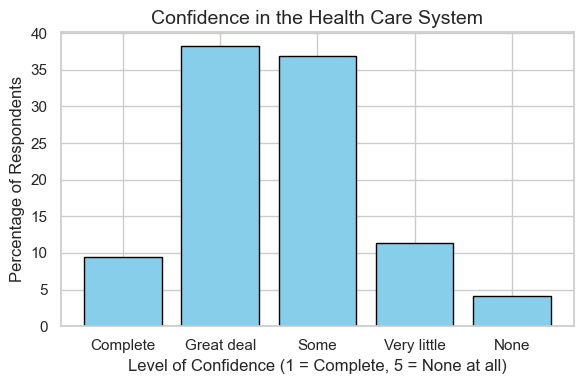

In [5]:
# Bar chart of Confidence in the Health Care System (V2):

# First we'll calculate the percentage distribution for V2 (ignoring None valid answers)
conf_counts = df['v2_num'].value_counts(normalize=True) * 100 # percentage distribution
conf_counts = conf_counts.sort_index()

labels = ['Complete','Great deal','Some','Very little','None']
positions = np.arange(len(labels))  # 0 to 4

# THis is the Plot
plt.figure(figsize=(6, 4))
plt.bar(positions, conf_counts.values, color='skyblue', edgecolor='black')
plt.title('Confidence in the Health Care System', fontsize=14)
plt.xlabel('Level of Confidence (1 = Complete, 5 = None at all)', fontsize=12)
plt.ylabel('Percentage of Respondents', fontsize=12)
plt.xticks(positions, labels)
plt.tight_layout()
plt.show()


### Interpretation:
 We can see that “Some confidence” is the most common response, followed by “A great deal of confidence.” Relatively few respondents have complete trust, and only a minority have no confidence at all in the system. This suggests most people have a moderate or cautiously positive view of their health care system, with extreme views (total trust or total distrust) being less common. The health care system seems to enjoy at least some confidence from a majority of respondents, though clearly there is room for improvement as not many are fully confident.

## 2. Frequency of Internet Use for Health Information – Distribution

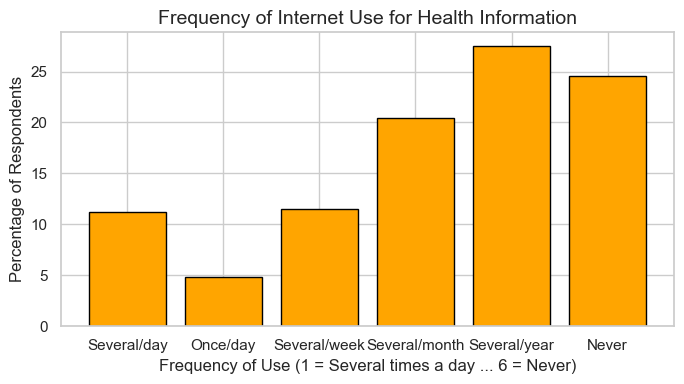

In [6]:
# Bar chart of Frequency of Internet Use for Health Information (V22):

# First we'll compute percentage distribution for V22 (internet usage frequency)
usage_counts = df['v22_num'].value_counts(normalize=True) * 100
usage_counts = usage_counts.sort_index()  # 1–6

labels = ['Several/day', 'Once/day', 'Several/week', 'Several/month', 'Several/year', 'Never']
positions = np.arange(len(labels))  # 0 to 5


plt.figure(figsize=(7, 4))
plt.bar(positions, usage_counts.values, color='orange', edgecolor='black')
plt.title('Frequency of Internet Use for Health Information', fontsize=14)
plt.xlabel('Frequency of Use (1 = Several times a day ... 6 = Never)', fontsize=12)
plt.ylabel('Percentage of Respondents', fontsize=12)
plt.xticks(positions, labels, rotation=0)
plt.tight_layout()
plt.show()


### Interpretation:
 There is a clear split in the population’s behavior:

* A significant proportion of respondents never (or almost never) go online for health information – this is evident from the tall bar at the “Never” category. This group might include those who either lack internet access, prefer traditional sources (like consulting doctors directly), or perhaps older individuals less accustomed to using the internet for health purposes.

* On the other end, we do have a smaller segment of frequent users: a noticeable bar for daily or weekly usage. These likely represent more digitally savvy individuals who regularly turn to Google, WebMD, or other online resources whenever they have health questions or needs.

* The middle categories (monthly or yearly) indicate occasional use by some people – they might look things up only when a specific need arises (e.g., a new medication or a health scare once in a while).



## 3. Internet Attitudes vs. Confidence in Healthcare – Comparative Analysis

To address our core question, we examine whether people’s trust in the health care system is related to how they view or use online health information. We’ll do two comparisons:

A) Belief that the Internet is useful to verify doctors’ advice, by confidence group: We split respondents into two groups – those with High confidence in the health care system (answered “Complete” or “A great deal of” confidence for v2) and those with Low confidence (“Very little” or “No confidence”). We then calculate what proportion of each group agrees that “the internet is useful to double-check advice from my doctor” (v29 being 1 or 2 on the agree scale).

Percent who agree Internet helps verify doctor - HIGH confidence group: 31.7%
Percent who agree Internet helps verify doctor - LOW confidence group: 37.7%


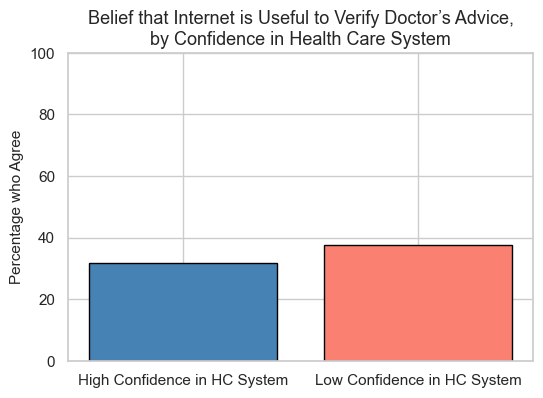

In [7]:
# Define high vs low confidence groups based on v2 (exclude middle "some confidence")
high_conf_mask = df['v2_num'].isin([1, 2])   # v2 = 1 or 2 => high confidence
low_conf_mask  = df['v2_num'].isin([4, 5])   # v2 = 4 or 5 => low confidence

high_conf_group = df[high_conf_mask]
low_conf_group  = df[low_conf_mask]

# Proportion in each group that agree (v29 == 1 or 2 means agree/strongly agree internet is useful to verify doctor)
prop_agree_high = (high_conf_group['v29_num'].isin([1, 2])).mean(skipna=True) * 100
prop_agree_low  = (low_conf_group['v29_num'].isin([1, 2])).mean(skipna=True) * 100

print(f"Percent who agree Internet helps verify doctor - HIGH confidence group: {prop_agree_high:.1f}%")
print(f"Percent who agree Internet helps verify doctor - LOW confidence group: {prop_agree_low:.1f}%")

# Bar chart comparing the two percentages
groups = ['High Confidence in HC System', 'Low Confidence in HC System']
values = [prop_agree_high, prop_agree_low]

plt.figure(figsize=(6,4))
plt.bar(groups, values, color=['steelblue','salmon'], edgecolor='black')
plt.title('Belief that Internet is Useful to Verify Doctor’s Advice,\nby Confidence in Health Care System', fontsize=13)
plt.ylabel('Percentage who Agree', fontsize=11)
plt.ylim(0, 100)
plt.show()



### Findings:
 There is a notable difference between the two groups:

* Among people with low confidence in the health care system, a higher proportion agree that the internet is useful for double-checking doctors.

* Those with high confidence in the system are less likely to see a need to verify their doctor’s advice online (a smaller percentage of this group agrees with the usefulness of internet for that purpose).

B) Frequency of Internet Use by confidence group: In addition to attitudes, let’s see actual behavior – do low-confidence individuals use the internet more often for health info than high-confidence individuals? We compare the distributions of internet usage frequency (v22) for the high vs. low confidence groups.

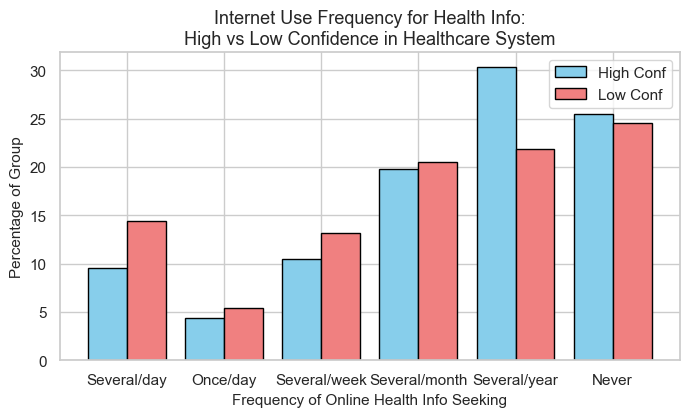

In [8]:
# Compare internet usage frequency distribution for high vs low confidence groups
usage_counts_high = high_conf_group['v22_num'].value_counts(normalize=True).sort_index() * 100
usage_counts_low  = low_conf_group['v22_num'].value_counts(normalize=True).sort_index() * 100

# Ensure all categories 1-6 are represented
freq_categories = range(1,7)
vals_high = [usage_counts_high.get(cat, 0) for cat in freq_categories]
vals_low  = [usage_counts_low.get(cat, 0) for cat in freq_categories]

# Plot side-by-side bar charts for high vs low confidence groups
labels = ['Several/day','Once/day','Several/week','Several/month','Several/year','Never']
x = np.arange(len(labels))
width = 0.4

plt.figure(figsize=(8,4))
plt.bar(x - width/2, vals_high, width, label='High Conf', color='skyblue', edgecolor='black')
plt.bar(x + width/2, vals_low,  width, label='Low Conf', color='lightcoral', edgecolor='black')
plt.title('Internet Use Frequency for Health Info:\nHigh vs Low Confidence in Healthcare System', fontsize=13)
plt.xlabel('Frequency of Online Health Info Seeking', fontsize=11)
plt.ylabel('Percentage of Group', fontsize=11)
plt.xticks(ticks=x, labels=labels, rotation=0)
plt.legend()
plt.show()


### Findings:
We observe clear differences in behavior:

* High-confidence individuals (those who trust the health system) are far more likely to never or very rarely seek health info online. Their tallest bar is at “Never”. This suggests that many in this group might rely on doctors or traditional sources for information, or simply have less inclination to double-check things on their own.

* Low-confidence individuals show a greater tendency to use the internet frequently. The low-confidence group has noticeably higher percentages in the frequent-use categories (daily/weekly). They are less represented in the “Never” category compared to the high-trust group.

## 4. The Demographic divide

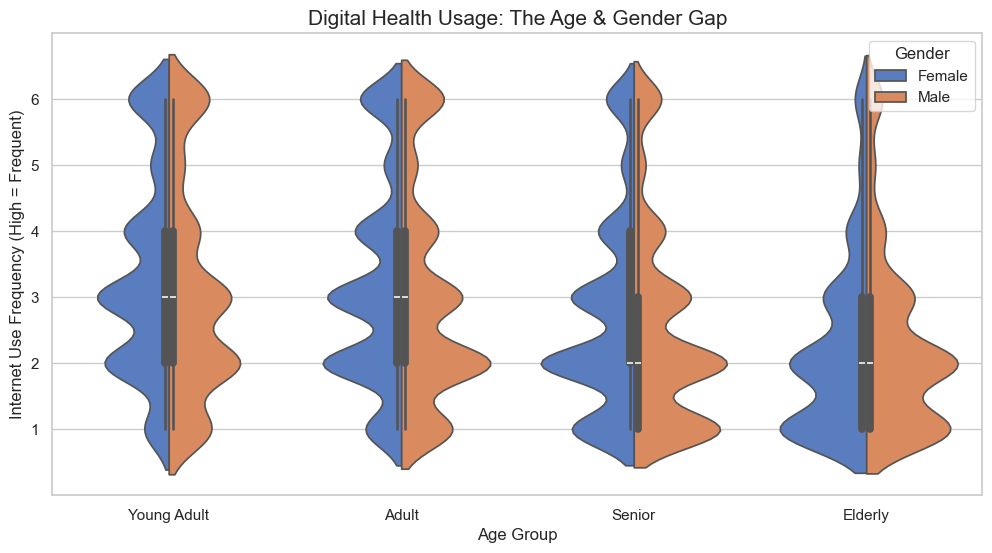

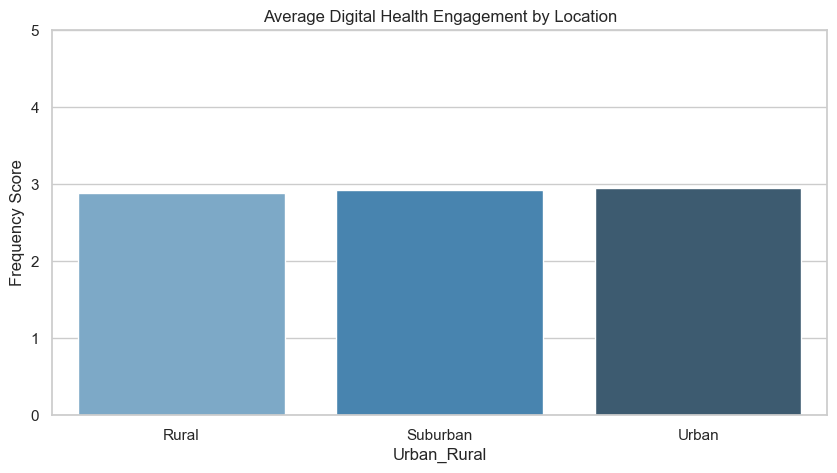

In [22]:
# Internet Usage by Age & Gender (Violin Plot)
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x='Age_Group', y='Internet_Freq', hue='Gender', split=True, palette='muted')
plt.title("Digital Health Usage: The Age & Gender Gap", fontsize=15)
plt.ylabel("Internet Use Frequency (High = Frequent)")
plt.xlabel("Age Group")
plt.legend(title='Gender', loc='upper right')
plt.show()

# The Urban-Rural Split
plt.figure(figsize=(10, 5))
avg_usage = df.groupby('Urban_Rural')['Internet_Freq'].mean().sort_values()

sns.barplot(
    x=avg_usage.index,
    y=avg_usage.values,
    hue=avg_usage.index,
    palette='Blues_d',
    legend=False
)

plt.title("Average Digital Health Engagement by Location")
plt.ylabel("Frequency Score")
plt.ylim(0, 5)
plt.show()

## 5. Internet usage intensity regarding health topics

In this section, we examine how frequently respondents use the internet for health-related information.
We create a new label, “frequency of internet use”, based on survey question v22, and categorize respondents into three groups:

High use

Medium use

Low use

We then use these groups as class labels to analyze whether respondents’ attitudes and behaviors regarding online health information (v23–v30) can predict their level of internet use.

This allows us to explore the relationship between internet usage frequency and perceived effectiveness of online health information.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

df = df.dropna()

df['internet_use_group'] = None
# High usage: 1–2 -> 2
df.loc[df['v22_num'] <= 2, 'internet_use_group'] = 2
# Medium usage: 3–4 -> 1
df.loc[(df['v22_num'] > 2) & (df['v22_num'] <= 4), 'internet_use_group'] = 1
# Low usage: 5 -> 0
df.loc[df['v22_num'] > 4, 'internet_use_group'] = 0

df['internet_use_group'] = df['internet_use_group'].astype(int)

X = df[['v23_num','v24_num','v25_num','v26_num','v27_num','v28_num','v29_num','v30_num']]
y = df['internet_use_group']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.57      0.71      0.63      2674
           1       0.46      0.39      0.42      1979
           2       0.29      0.17      0.21       976

    accuracy                           0.50      5629
   macro avg       0.44      0.42      0.42      5629
weighted avg       0.48      0.50      0.48      5629



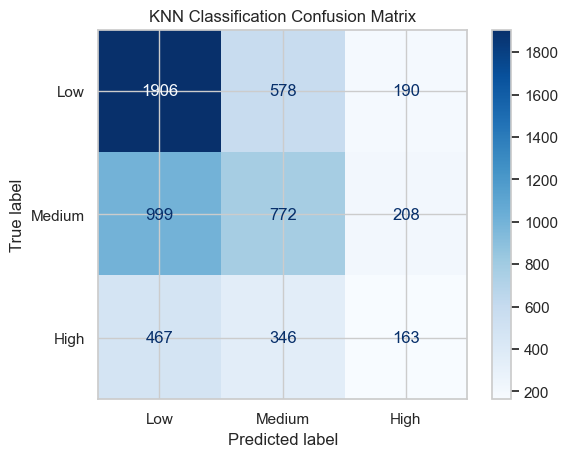

In [11]:

cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Low', 'Medium', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("KNN Classification Confusion Matrix")
plt.show()


As we can see from the confusion matrix, the KNN model is not particularly effective for predicting internet usage frequency based on the survey questions.

For respondents labeled as “Low use”, the model predicts fairly accurately.

For “Medium use” and “High use” respondents, predictions are much less reliable.

We attribute this to a couple of factors:

The Low use group is the largest, meaning it dominates the dataset and causes the algorithm to favor this group, even when lowering the k value.

There may be overlap in survey responses between groups, which leads to misclassification of Medium and High users.

In conclusion, while the model performs slightly better than random guessing, it is not strong enough to suggest a clear connection between survey responses and internet usage intensity.

Cluster summaries (average values per feature):
          v22_num   v23_num   v24_num   v25_num   v26_num   v27_num   v28_num  \
cluster                                                                         
0        3.263661  3.461502  3.021877  3.289137  2.492660  2.410077  2.607444   
1        4.830775  2.062274  1.535380  2.042681  3.811806  3.849619  3.876201   
2        4.338836  2.171873  1.570996  2.136140  2.659283  2.468081  2.351269   

          v29_num   v30_num  
cluster                      
0        2.724122  2.348234  
1        4.008985  2.087233  
2        2.477484  2.412705  


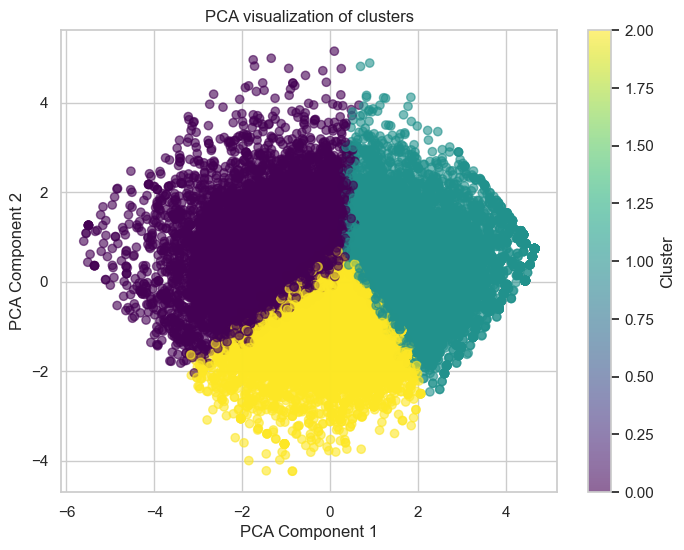

In [12]:

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

features = ['v22_num','v23_num','v24_num','v25_num','v26_num','v27_num','v28_num','v29_num','v30_num']
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df['cluster'] = clusters

cluster_summary = df.groupby('cluster')[features].mean()
print("Cluster summaries (average values per feature):")
print(cluster_summary)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='viridis', alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA visualization of clusters')
plt.colorbar(label='Cluster')
plt.show()


After trying KNN, we decided that labeling respondents upfront might not be the best approach, so we switched to an unsupervised learning method, K-Means.

We selected all features related to internet usage and behavior (v22–v30) to see if the data naturally forms clusters that could reflect different patterns of internet use. We intentionally chose K = 3 to explore whether respondents could be grouped meaningfully.

After running the K-Means algorithm, we found that the data does have a noticeable structure. Based on the average value of v22 (Frequency of internet use for health information), we can interpret the clusters as:

Cluster 1 – High Use

Cluster 0 – Medium Use

Cluster 2 – Low Use

This shows that the clustering captures patterns of internet use even without predefined labels, supporting the idea that respondents’ behavior and attitudes naturally separate them into distinct groups.

Looking at the averages of the different questions across clusters confirms this interpretation.

Questions v26–v30 were answered on a scale from 1 = Strongly agree to 5 = Strongly disagree:

v26: Information from the internet has positively affected my health behaviors

v27: Information from the internet helped me understand my doctor better

v28: Using the internet is useful for deciding how to treat an illness or whether to see a doctor

v29: The internet is useful to double-check advice from my doctor

v30: It is not easy to distinguish reliable health information on the internet

The averages align with our cluster labeling. The Low Use cluster (Cluster 2) shows higher average scores for these items, indicating less positive impact or trust in internet information.

Examining the topic-specific questions v23–v25 (seeking information on lifestyle, mental health, and vaccinations), we see that the High Use group (Cluster 1) has slightly higher averages, meaning they are less active in these specific topics than we initially expected. This suggests that frequent internet users do not necessarily search all health topics equally; they may use the internet more broadly or for other purposes.

Looking more closely at v28 and v30:

v28 is lower in the High Use group (Cluster 1), which aligns with our expectation that they actively use the internet for health decisions.

v30, which measures difficulty distinguishing reliable information, shows that the High Use group is more aware of this problem than the Medium Use group, suggesting frequent users recognize misinformation risks.

The Low Use group has the lowest average for v30, raising the question: do they avoid using the internet because they are aware of misinformation, or is it due to myths, misconceptions, or lack of confidence in online health information?

Overall, the clustering reveals distinct patterns in internet usage and highlights that high frequency does not always mean high engagement with every specific health topic, providing nuanced insight into respondents’ behavior.

<Figure size 1200x600 with 0 Axes>

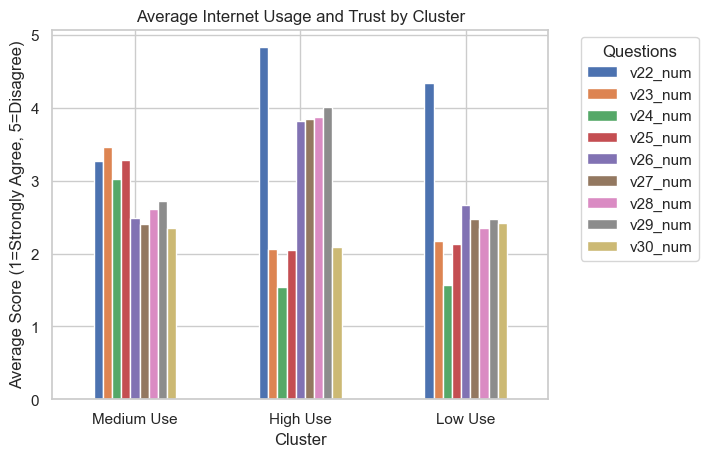

<Figure size 1000x500 with 0 Axes>

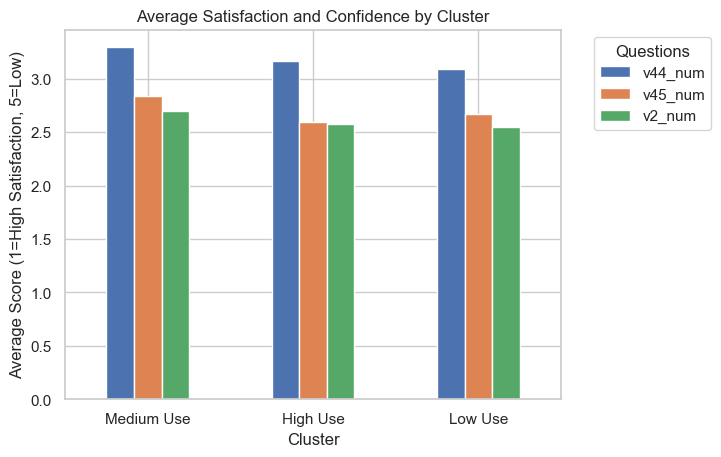

In [13]:

internet_features = [
    'v22_num','v23_num','v24_num','v25_num',
    'v26_num','v27_num','v28_num','v29_num','v30_num'
]
satisfaction_features = ['v44_num','v45_num']
confidence_features = ['v2_num']


features = internet_features + satisfaction_features + confidence_features


df[features] = df[features].apply(pd.to_numeric, errors='coerce')


cluster_means = df.groupby('cluster')[features].mean()


cluster_means.index = ['Medium Use','High Use','Low Use']


plt.figure(figsize=(12,6))
cluster_means[internet_features].plot(kind='bar', rot=0)
plt.title("Average Internet Usage and Trust by Cluster")
plt.ylabel("Average Score (1=Strongly Agree, 5=Disagree)")
plt.xlabel("Cluster")
plt.legend(title="Questions", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


plt.figure(figsize=(10,5))
cluster_means[satisfaction_features + confidence_features].plot(kind='bar', rot=0)
plt.title("Average Satisfaction and Confidence by Cluster")
plt.ylabel("Average Score (1=High Satisfaction, 5=Low)")
plt.xlabel("Cluster")
plt.legend(title="Questions", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In addition to internet usage patterns, we examined respondents’ confidence in the healthcare system (v2) and satisfaction with healthcare services (v44, v45) across the clusters. The bar chart of cluster averages shows that these measures are relatively similar across Low, Medium, and High Use clusters.

For v44 (satisfaction with the healthcare system) and v45 (satisfaction with last visit to a doctor), there is no substantial difference between clusters, suggesting that frequency of internet use for health information does not strongly correlate with satisfaction.

Similarly, v2 (confidence in the healthcare system) averages remain largely consistent across clusters, indicating that confidence in healthcare is not directly influenced by internet usage intensity.

These findings imply that while K-Means clustering highlights distinct behavioral patterns in internet use and perceptions of online health information (v22–v30), it does not reveal a clear relationship with overall satisfaction or trust in the healthcare system. This supports the conclusion that high or low internet usage does not necessarily correspond to positive or negative perceptions of healthcare services.

## 6. Do internet health usage patterns and attitudes differ between developed and developing countries?
In this segment, we explore whether the patterns observed in our previous clustering analysis differ between countries, or whether the generalization across all countries was reasonable.

We will take a sample of respondents from six countries and compare them based on their internet health usage and attitudes. The countries were selected to represent both developed and developing countries, and to capture differences in culture, internet access, and healthcare systems:

1. Israel – culturally relevant and technologically advanced
2. Switzerland – the country with the most respondents, providing a robust sample
3. USA – representing a western, highly developed country
4. South Africa – a developing country with distinct socio-economic conditions
5. China – internet access is regulated and culturally different from the West
6. India – a large developing country with diverse demographics

In [14]:
country_counts = df['country'].value_counts()
print(country_counts)

country
756. CH-Switzerland       2504
710. ZA-South Africa      1717
156. CN-China             1339
158. TW-Taiwan            1298
276. DE-Germany           1168
208. DK-Denmark           1088
643. RU-Russia            1022
608. PH-Philippines       1020
40. AT-Austria            1011
250. FR-France            1002
376. IL-Israel             986
203. CZ-Czech Republic     919
191. HR-Croatia            855
840. US-United States      850
380. IT-Italy              814
578. NO-Norway             805
528. NL-Netherlands        799
705. SI-Slovenia           770
703. SK-Slovakia           768
348. HU-Hungary            762
356. IN-India              756
554. NZ-New Zealand        751
484. MX-Mexico             740
352. IS-Iceland            723
764. TH-Thailand           703
36. AU-Australia           674
246. FI-Finland            653
392. JP-Japan              609
740. SR-Suriname           559
616. PL-Poland             478
Name: count, dtype: int64


In [15]:

selected_countries = [
    '376. IL-Israel',
    '756. CH-Switzerland',
    '840. US-United States',
    '710. ZA-South Africa',
    '156. CN-China',
    '356. IN-India'
]

df_subset = df[df['country'].isin(selected_countries)].copy()

df_subset['country_label'] = df_subset['country'].str.extract(r'\. (.*)')
label_order = [c.split('. ')[1] for c in selected_countries]

cluster_map = {0: 'Medium Use', 1: 'High Use', 2: 'Low Use'}
df_subset['cluster_name'] = df_subset['cluster'].map(cluster_map)


We will examine the data from three complementary perspectives in order to understand how country context relates to internet health behavior and attitudes:

1. Cluster Distribution
We analyze how respondents are distributed across the previously identified internet-use clusters, comparing developed countries with developing (third-world) countries. This allows us to assess whether general internet usage patterns differ systematically by level of national development.

2. Internet Use and Attitudes Toward Online Health Information
We compare countries based on responses to internet-related health questions, focusing on how frequently respondents use the internet for health purposes and how useful, helpful, and trustworthy they perceive online health information to be. This perspective helps identify whether country context influences both usage intensity and perceived value of online health resources.

3. Confidence and Satisfaction with the Health System
Finally, we examine cross-country differences in respondents’ confidence in and satisfaction with their healthcare systems. This analysis explores whether national context is associated with varying levels of trust in formal healthcare institutions, and whether these differences align with patterns of internet health usage.

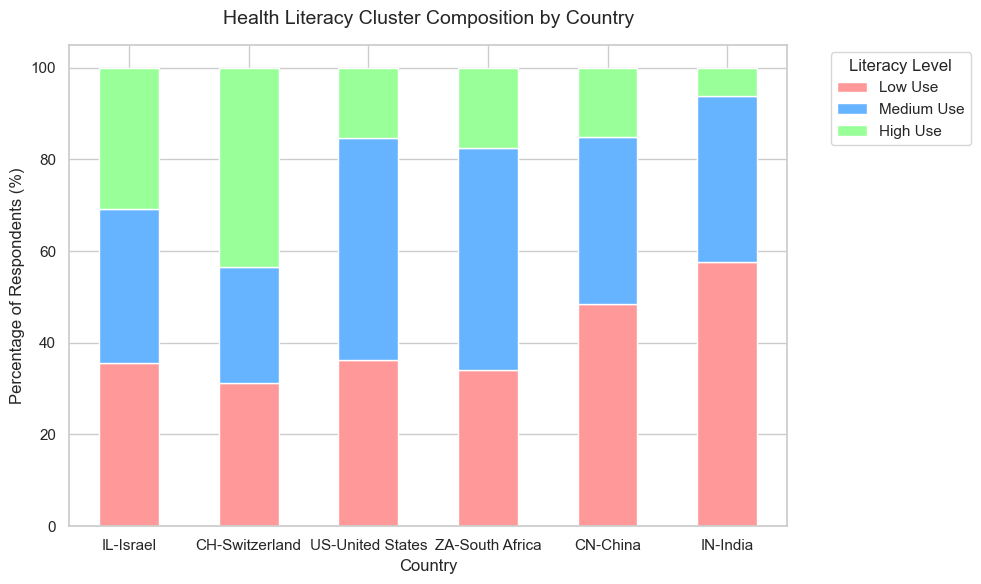

In [16]:

cluster_dist = pd.crosstab(df_subset['country_label'], df_subset['cluster_name'], normalize='index') * 100
cluster_dist = cluster_dist.reindex(label_order) # Ensure correct order

plt.figure(figsize=(10, 6))

ordered_columns = ['Low Use', 'Medium Use', 'High Use']

cluster_dist[ordered_columns].plot(
    kind='bar',
    stacked=True,
    ax=plt.gca(),
    color=['#ff9999', '#66b3ff', '#99ff99'],
    edgecolor='white'
)

plt.title("Health Literacy Cluster Composition by Country", fontsize=14, pad=15)
plt.ylabel("Percentage of Respondents (%)", fontsize=12)
plt.xlabel("Country", fontsize=12)
plt.legend(title="Literacy Level", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [17]:

df_subset['Age_num'] = pd.to_numeric(df_subset['Age'], errors='coerce')

median_ages = df_subset.groupby('country_label')['Age_num'].median()

median_ages = median_ages.reindex(label_order)

print("Median Age per Country:")
print(median_ages)

Median Age per Country:
country_label
IL-Israel           40.0
CH-Switzerland      51.0
US-United States    49.0
ZA-South Africa     39.0
CN-China            40.0
IN-India            34.0
Name: Age_num, dtype: float64


# Cluster Composition by Country

The cluster distribution largely aligns with expectations. Developing countries such as India and China show a lower proportion of High Use respondents and a higher proportion of Low Use respondents compared to developed countries, indicating lower engagement with online health information.

An exception is South Africa, where the share of High Use respondents is similar to that of the United States. This may be partly explained by South Africa’s large respondent sample, which captures a wider range of behaviors, as well as by structural challenges in its healthcare system. Inequalities between the public and private sectors and limited access to care may encourage greater reliance on online health information.

In developed countries, the Medium Use cluster is dominant. This pattern may be influenced by demographic factors, as countries such as South Africa and India have younger populations, which can affect how individuals access and use health information online.

Overall, these findings suggest that internet health usage patterns are shaped not only by a country’s development level, but also by healthcare accessibility and population demographics.

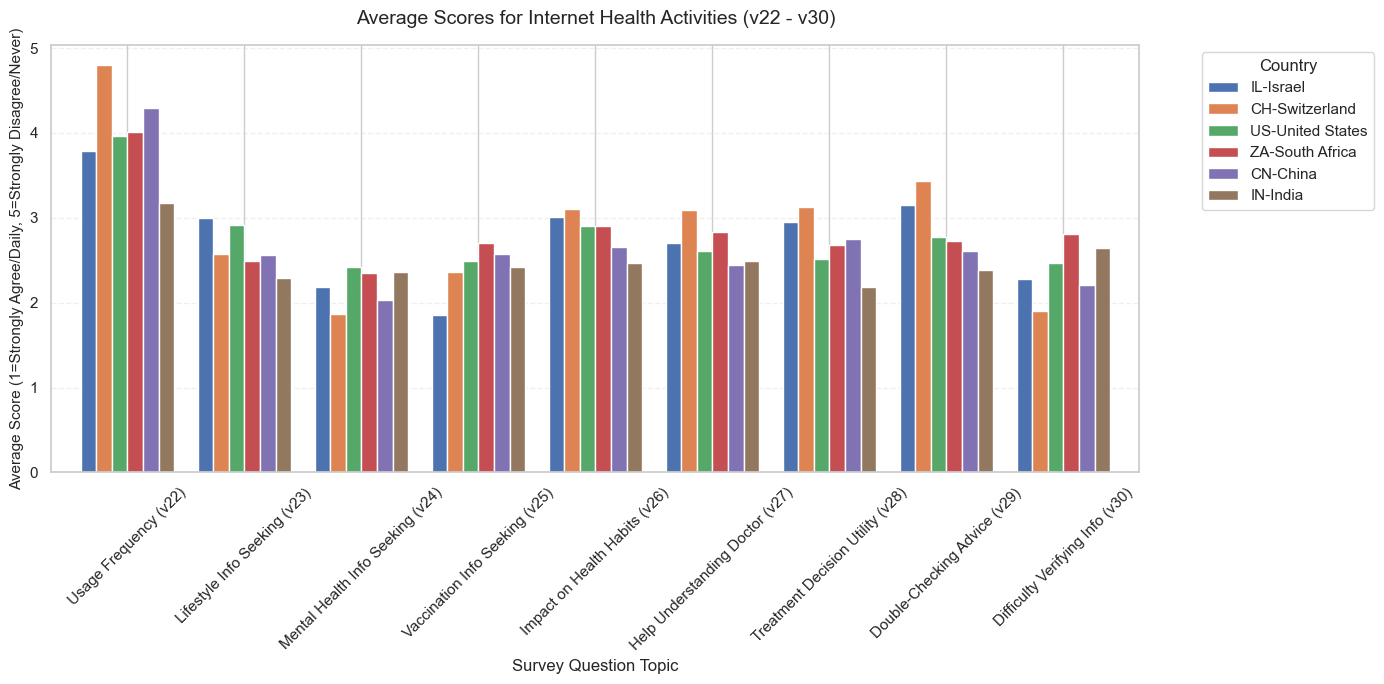

In [18]:

internet_features = ['v22_num','v23_num','v24_num','v25_num','v26_num','v27_num','v28_num','v29_num', 'v30_num']

internet_labels = [
    'Usage Frequency (v22)',
    'Lifestyle Info Seeking (v23)',
    'Mental Health Info Seeking (v24)',
    'Vaccination Info Seeking (v25)',
    'Impact on Health Habits (v26)',
    'Help Understanding Doctor (v27)',
    'Treatment Decision Utility (v28)',
    'Double-Checking Advice (v29)',
    'Difficulty Verifying Info (v30)'
]

internet_means = df_subset.groupby('country_label')[internet_features].mean().reindex(label_order)

plt.figure(figsize=(14, 7))
internet_means.T.plot(kind='bar', ax=plt.gca(), width=0.8)

plt.title("Average Scores for Internet Health Activities (v22 - v30)", fontsize=14, pad=15)
plt.ylabel("Average Score (1=Strongly Agree/Daily, 5=Strongly Disagree/Never)", fontsize=11)
plt.xlabel("Survey Question Topic", fontsize=12)
plt.xticks(ticks=range(len(internet_labels)), labels=internet_labels, rotation=45)
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Internet Use and Attitudes Toward Online Health Information by Country

When comparing average scores for v22 (frequency of internet use for health information) and v29 (checking online after a doctor visit), respondents from Switzerland and China appear less engaged with online health information than other countries. In Switzerland, this may be supported by the fact that its healthcare system is widely ranked among the best globally, with strong quality and infrastructure that could reduce reliance on internet searches for health advice.

In China, lower engagement with online health resources may reflect a combination of high reported levels of trust in doctors and systemic influences on healthcare interactions, rather than a simple cultural “obedience” norm.

Across all countries, consistently low averages for v24 suggest limited seeking of mental health information, aligning with broader societal patterns in many regions. Respondents from developing and Third World countries also show lower scores on v30, indicating they may find it harder to distinguish reliable online information. This could reflect differences in internet access, digital health literacy, and healthcare system experience, suggesting that both structural and educational factors shape how people use and evaluate online health resources.

# Healthcare System Confidence & Satisfaction by Country

In this chart, lower average scores indicate higher confidence and satisfaction, while higher scores reflect lower trust.

Switzerland shows relatively Lower average scores, indicating high reported confidence and satisfaction, which aligns with our earlier findings that Swiss respondents rely less on online health information.

In contrast, the United States also shows relatively high scores on these measures, indicating low reported confidence and satisfaction. This aligns with well-documented differences between the U.S. and many developed systems: the U.S. has some of the highest healthcare costs globally, with substantial private spending and administrative complexity. It also consistently ranks lower on population-level healthcare outcomes relative to spending in international comparisons, which can contribute to lower trust and satisfaction among the public

however , it seems that across countries the differences are not dramatic, suggesting that confidence in healthcare systems is not strongly determined by country alone. Instead, individual experiences, system accessibility, and perceived costs likely play a larger role than national context.

# Insights & Interpretation

Bringing together the exploration above, we can summarize key insights and what they might mean:


* General Trust in Healthcare: Most respondents have moderate confidence in their country’s health care system, with relatively few at the extremes. People tend to be more satisfied with their personal healthcare experiences (doctors visits) than with the healthcare system overall. This suggests individual healthcare providers might be doing a good job even if people have criticisms of the broader system (e.g., waiting times, costs, administration).

* Prevalence of Online Health Information Seeking: There is a digital divide in health information behavior. A considerable share of people (likely older or less tech-oriented) rarely uses the internet for health info, whereas a subset of the population uses it frequently (daily/weekly). The fact that so many never use it could have implications for public health outreach – information posted online (like pandemic guidelines) might not reach those who aren’t looking for it.

* Popular Online Health Topics: Among those who do go online, the most commonly searched topics are general health and wellness (lifestyle), followed by mental health and vaccinations. The high interest in vaccination info in 2021 is notable – likely driven by COVID-19 vaccine rollout and debates. It highlights that people seek clarity and knowledge on critical and timely health issues via the internet.

* Impact of Online Information: Many people report positive outcomes from using the internet for health – such as making healthier lifestyle changes or better understanding medical instructions. This is an encouraging sign that the internet can complement healthcare by empowering patients with more understanding and motivation. However, it’s not universal; some did not experience changes, indicating that information alone doesn’t always translate to action (or they already had good habits/understanding to begin with).

* Trust in Online Info vs Doctors: There’s a nuanced view of online health information:

    * On one hand, a majority see the internet as a helpful tool for making health decisions and verifying what doctors say. This implies that even if they trust doctors, people like having a way to double-check or gather more input – essentially combining professional advice with their own research.

    * On the other hand, concerns about reliability are very common – the average person isn’t blindly trusting internet info. They are aware that not everything online is accurate, which reflects a healthy skepticism and the need for guidance in finding credible sources.

    * These mixed attitudes show that online resources are a double-edged sword: they empower and inform patients, but also can mislead or overwhelm them if they cannot discern quality information. The medical community and public health authorities might leverage the positive (by guiding people to good resources) and mitigate the negative (educating about misinformation).

* Relationship between Digital Engagement and Trust in Healthcare: Our exploratory analysis suggests a noteworthy pattern: individuals who have lower trust in the health care system or providers tend to engage more with online health information. Specifically, they are more likely to frequently search the internet about health and to trust what they find there enough to use it as a second opinion. Conversely, those who highly trust the system are less inclined to seek external information – presumably because they feel the information from their doctors is sufficient or because they are less inclined to question it.

    * This raises important questions: Does distrust drive people to Google, or does googling (and perhaps encountering conflicting information or negative stories) feed distrust? The data at least confirm these two aspects are linked. It might be a feedback loop as well.

    * There could also be third factors involved – for example, younger people might both use the internet more and have different expectations from healthcare (thus appearing less “confident” in it), whereas older folks trust doctors more and don’t use internet as much. In that case, age (or education) would be an underlying factor influencing both. We haven’t yet delved into demographic splits, but that would be a logical next step.

In summary, our initial exploration highlights a tension between traditional healthcare trust and the new paradigm of information access. People increasingly have the means to inform themselves and cross-check professionals, which can be empowering but also reflects underlying trust issues.

* For further discussions / explorations , refer to the presentation.